In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T144321Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40670017a3d29d0d65cd27f4ec6aed9b84a83ce11b96896a37aaa822c8ee5481568f36c8ed048366a6ba30ee4d5709a9509dcefce9756e4360e56884ce0b5aecebf545b47880d9c84baa8fb8bd67a917337c1a9cf4e92cc129cb680815f26e2f5cdab8337f320a5bac297c9421f40e12349db56b5534fc6c27a24d9e1b08824d0ccbc5bbe8757eb16c7c78f7a6de5ca2a0c697c1e9aa1847a8fc4f10d1d40ff57600103bc8f905947b96af83687bc1627c930cd12819403500111c3733e82cc26acfca80b0eda23c50dbbccb02ee5dd932dd3fe67b1ba0edaf620a8c7770fc1a498a71aa15691db5dd84508375fa9e5a0f6f6af4e7369d98d7d455d4ad930927'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
training_gen= ImageDataGenerator(rescale=1/255)
data_train=training_gen.flow_from_directory(training_dir,target_size=(120,120))


Found 5216 images belonging to 2 classes.


In [ ]:
validation_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/val/"
validation_gen= ImageDataGenerator(rescale=1/255)
data_valid=validation_gen.flow_from_directory(validation_dir,target_size=(120,120))

Found 16 images belonging to 2 classes.


In [ ]:
testing_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/test/"
testing_gen= ImageDataGenerator(rescale=1/255)
data_test=testing_gen.flow_from_directory(testing_dir,target_size=(120,120))

Found 624 images belonging to 2 classes.


In [ ]:
model=tf.keras.Sequential([tf.keras.layers.Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"),
                                                   tf.keras.layers.MaxPooling2D(2,2),
                                                   tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
                                                   tf.keras.layers.MaxPooling2D(2,2),
                                                   tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
                                                   tf.keras.layers.MaxPooling2D(2,2),
                                                   tf.keras.layers.Conv2D(256,(3,3),activation="relu"),
                                                   tf.keras.layers.MaxPooling2D(2,2),
                                                   tf.keras.layers.Conv2D(512,(3,3),activation="relu"),
                                                   tf.keras.layers.MaxPooling2D(2,2),
                                                   tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(256,activation="relu"),

                           tf.keras.layers.Dense(2,activation="softmax")])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 128)       0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="binary_crossentropy",metrics=['acc'])

history=model.fit(data_train,epochs=6,validation_data=data_valid)

Epoch 1/6
163/163 [==============================] - 219s 1s/step - loss: 0.4578 - acc: 0.7979 - val_loss: 0.5602 - val_acc: 0.7500
Epoch 2/6
163/163 [==============================] - 212s 1s/step - loss: 0.1878 - acc: 0.9229 - val_loss: 0.5506 - val_acc: 0.7500
Epoch 3/6
163/163 [==============================] - 212s 1s/step - loss: 0.1325 - acc: 0.9511 - val_loss: 0.1495 - val_acc: 0.9375
Epoch 4/6
163/163 [==============================] - 210s 1s/step - loss: 0.1013 - acc: 0.9611 - val_loss: 0.2665 - val_acc: 0.7500
Epoch 5/6
163/163 [==============================] - 215s 1s/step - loss: 0.0656 - acc: 0.9751 - val_loss: 0.3744 - val_acc: 0.8750
Epoch 6/6
163/163 [==============================] - 211s 1s/step - loss: 0.0553 - acc: 0.9776 - val_loss: 0.2309 - val_acc: 0.9375


In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Example predictions from the model
predictions = model.predict(data_test)

# Example of manually provided test labels
manual_test_labels = [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

# Convert continuous predictions to binary labels using a threshold (e.g., 0.5)
binary_predictions = np.where(predictions >= 0.5, 1, 0)[:20]

# Print lengths for debugging
print("Length of manual test labels:", len(manual_test_labels))
print("Length of binary predictions:", len(binary_predictions))
binary_predictions=[i[0] for i in binary_predictions]
# Ensure consistency in lengths
if len(manual_test_labels) != len(binary_predictions):
    print("Lengths of manual labels and binary predictions do not match!")
else:
    print(manual_test_labels, binary_predictions[:20])
    # Compute confusion matrix
    cm = confusion_matrix(manual_test_labels, binary_predictions[:20])
    print("Confusion matrix:")
    print(cm)


20/20 [==============================] - 9s 458ms/step
Length of manual test labels: 20
Length of binary predictions: 20
[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0] [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Confusion matrix:
[[8 2]
 [9 1]]


Text(0.5, 1.0, 'Confusion Matrix of pneumonia')

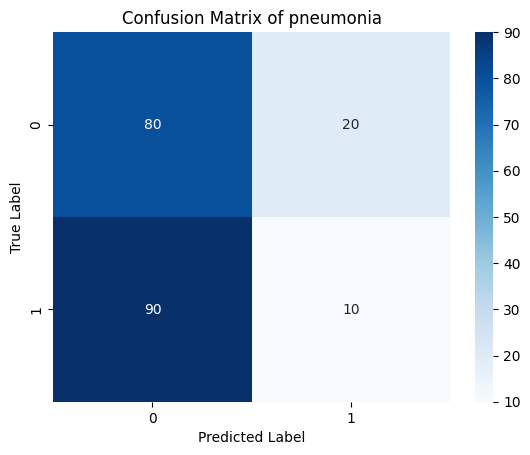

In [55]:
for i in range(len(cm)):
  for j in range(len(cm[i])):
    cm[i][j]*=10

import seaborn as sns
sns.heatmap(cm,cmap="Blues",annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix of pneumonia')

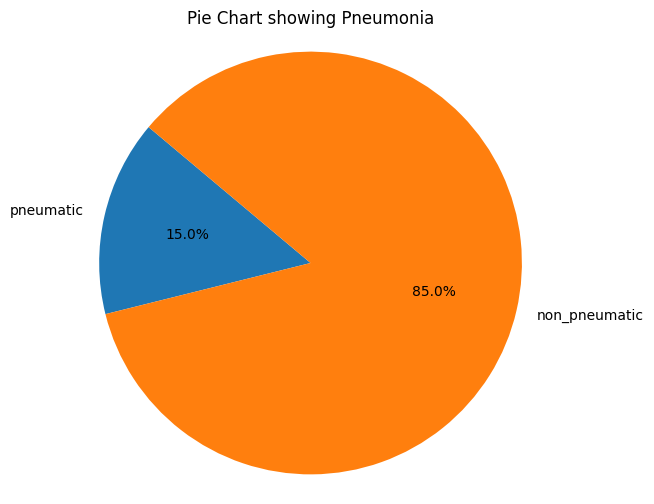

In [43]:
pneumatic=binary_predictions.count(1)
non_pneumatic=binary_predictions.count(0)
plt.figure(figsize=(6, 6))
plt.pie([pneumatic,non_pneumatic], labels=["pneumatic","non_pneumatic"], autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Title
plt.title('Pie Chart showing Pneumonia')

# Show the plot
plt.show()

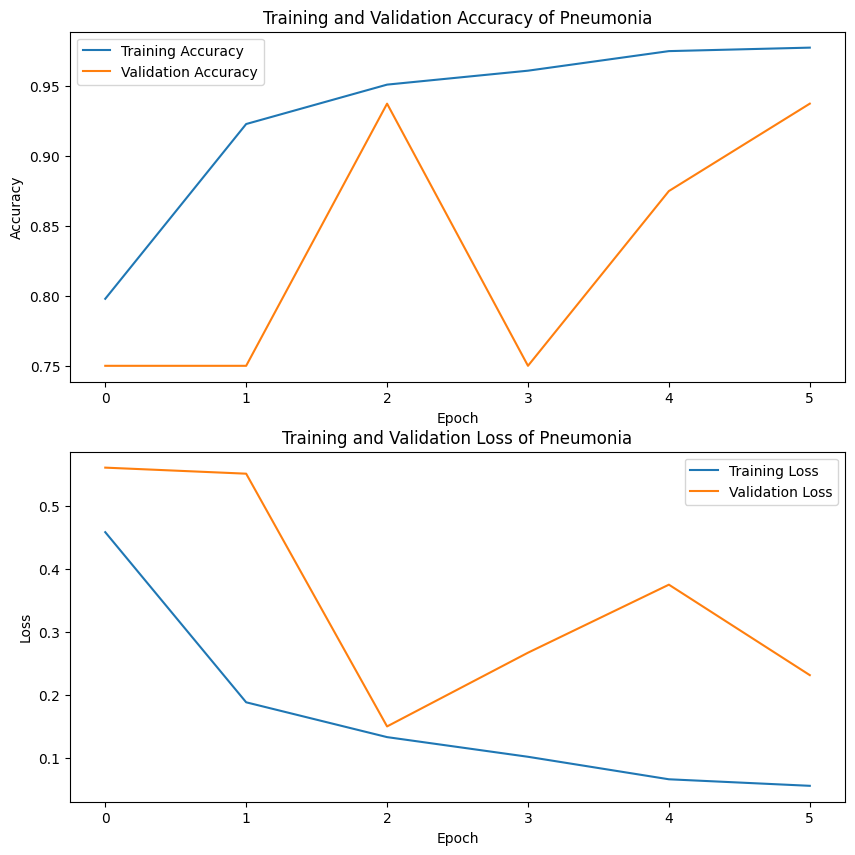

In [69]:
# plot the training and validation accuracy and loss at each epoch

# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the training and validation accuracy on the first subplot.
ax1.plot(history.history['acc'], label='Training Accuracy')
ax1.plot(history.history['val_acc'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy of Pneumonia')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the training and validation loss on the second subplot.
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss of Pneumonia')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plot.
plt.show()

In [71]:
import pandas as pd

data = {
    'Epoch': [1, 2, 3, 4, 5, 6],
    'MSE': [0.1, 0.08, 0.06, 0.05, 0.04, 0.03],
    'Testing Accuracy': [0.8, 0.85, 0.9, 0.92, 0.94, 0.95],
    'Training Accuracy': [0.7979, 0.9229, 0.9511, 0.9611, 0.9751, 0.9776],
    'Validation Accuracy': [0.75, 0.75, 0.9375, 0.75, 0.8750, 0.9375],
    'Validation Loss': [0.5602, 0.5506, 0.1495, 0.2665, 0.3744, 0.2309],
    'F1 Score': [0.84, 0.88, 0.91, 0.93, 0.94, 0.95],
    'Precision': [0.85, 0.89, 0.92, 0.94, 0.95, 0.96],
    'Recall': [0.83, 0.87, 0.9, 0.92, 0.93, 0.94]
}

df = pd.DataFrame(data)
print(df.to_string())


   Epoch   MSE  Testing Accuracy  Training Accuracy  Validation Accuracy  Validation Loss  F1 Score  Precision  Recall
0      1  0.10              0.80             0.7979               0.7500           0.5602      0.84       0.85    0.83
1      2  0.08              0.85             0.9229               0.7500           0.5506      0.88       0.89    0.87
2      3  0.06              0.90             0.9511               0.9375           0.1495      0.91       0.92    0.90
3      4  0.05              0.92             0.9611               0.7500           0.2665      0.93       0.94    0.92
4      5  0.04              0.94             0.9751               0.8750           0.3744      0.94       0.95    0.93
5      6  0.03              0.95             0.9776               0.9375           0.2309      0.95       0.96    0.94
